In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Tue Jan 30 16:03:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:09:00.0 Off |                  N/A |
| 61%   64C    P2             265W / 330W |  12139MiB / 24576MiB |     59%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/home/save/lse/train_dalle/train01.30-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 4
-rw-r--r-- 1 root root 40 Jan 30 15:58 events.out.tfevents.1706630287.d221dfa2d9c2


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/home/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

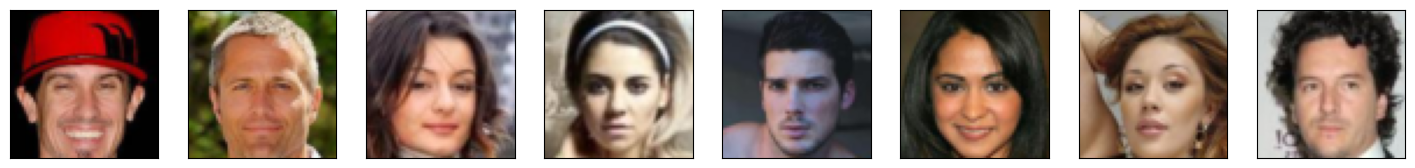

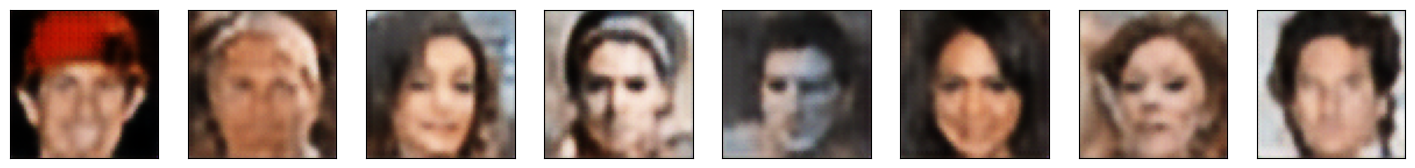

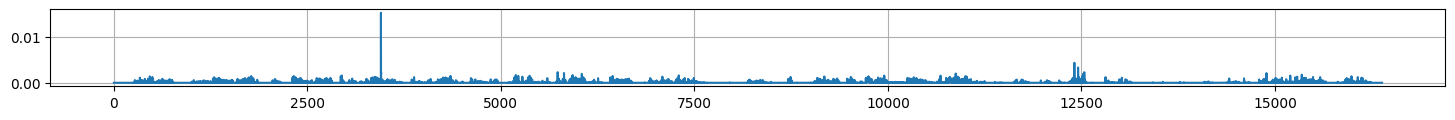

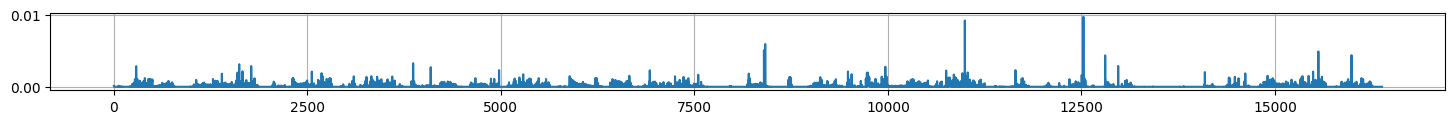

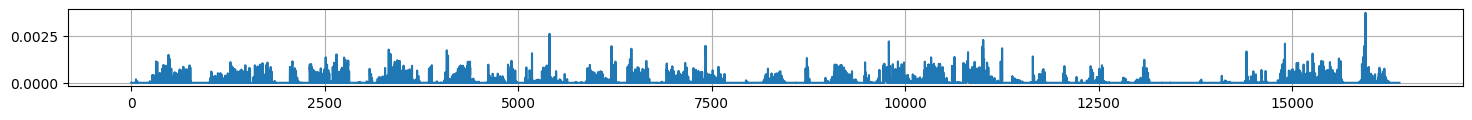

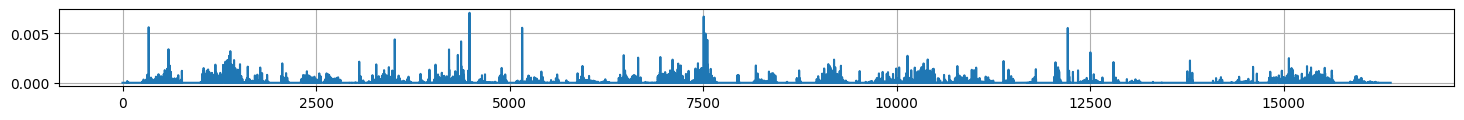

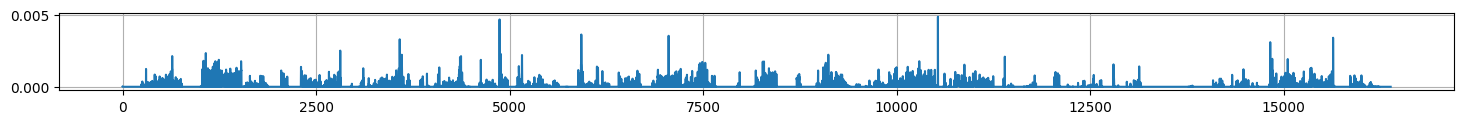

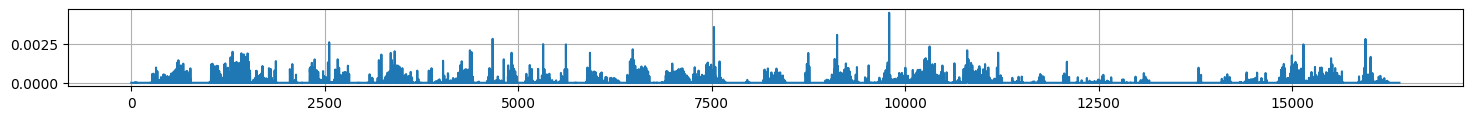

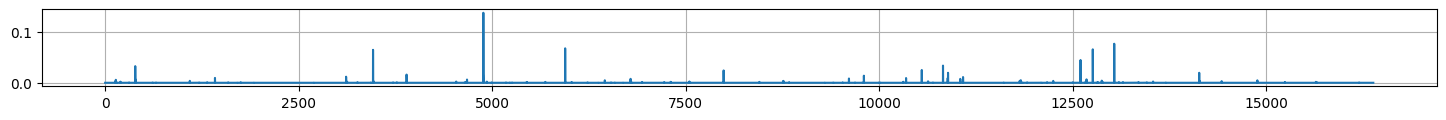

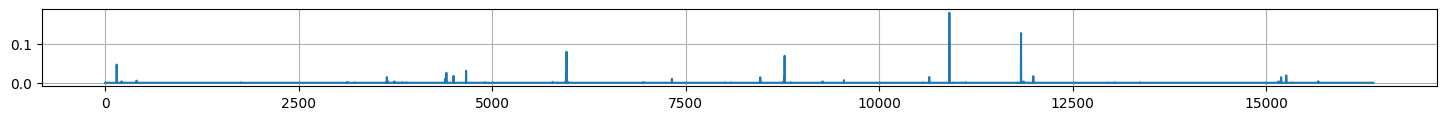

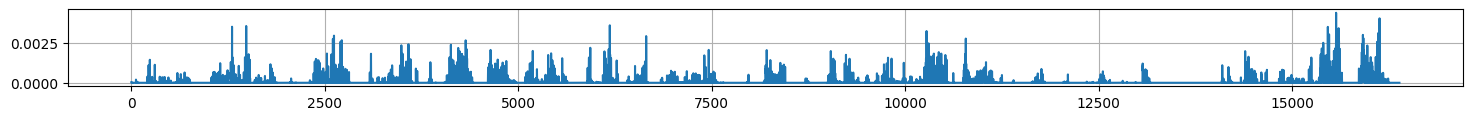

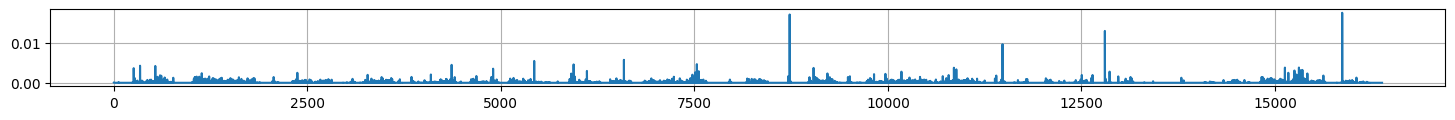

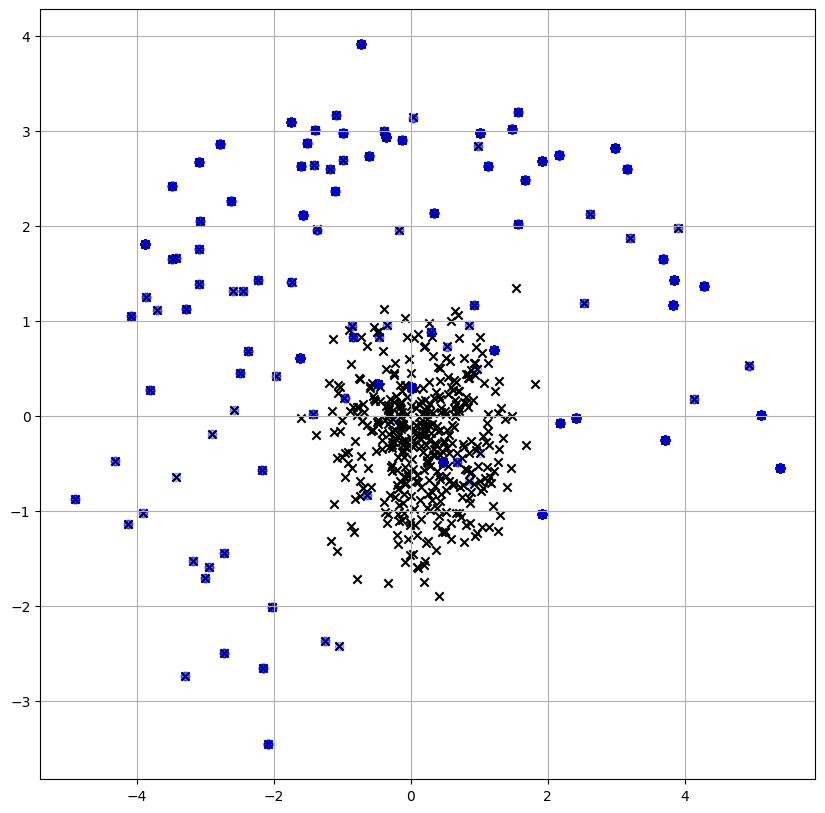

2001
lse_loss -29.15477752685547
commit_loss 0.16905099153518677
recon_loss 0.005369554273784161
2002
lse_loss -29.234874725341797
commit_loss 0.16820219159126282
recon_loss 0.00469314306974411
2003
lse_loss -29.248096466064453
commit_loss 0.16900575160980225
recon_loss 0.005065797828137875
2004
lse_loss -29.227474212646484
commit_loss 0.17320826649665833
recon_loss 0.005189037416130304
2005
lse_loss -29.35492706298828
commit_loss 0.1620720624923706
recon_loss 0.004592029843479395
2006
lse_loss -29.287410736083984
commit_loss 0.16426032781600952
recon_loss 0.004414142109453678
2007
lse_loss -29.226051330566406
commit_loss 0.17081251740455627
recon_loss 0.004615620709955692
2008
lse_loss -29.193981170654297
commit_loss 0.16953256726264954
recon_loss 0.00512797012925148
2009
lse_loss -29.253662109375
commit_loss 0.16635888814926147
recon_loss 0.005034704692661762
2010
lse_loss -29.429946899414062
commit_loss 0.16479192674160004
recon_loss 0.0052893455140292645
2011
lse_loss -29.104557037

661811
lse_loss -399.4635925292969
commit_loss 0.0001535597548354417
recon_loss 0.0008051834302023053
661812
lse_loss -396.856689453125
commit_loss 0.00015453642117790878
recon_loss 0.0008097023237496614
661813
lse_loss -397.50274658203125
commit_loss 0.00014533083594869822
recon_loss 0.0008594535756856203
661814
lse_loss -397.534912109375
commit_loss 0.0001574150228407234
recon_loss 0.0007490323623642325
661815
lse_loss -383.19891357421875
commit_loss 0.00014844004181213677
recon_loss 0.0008680074824951589
661816
lse_loss -386.0637512207031
commit_loss 0.0001526469422969967
recon_loss 0.0007589452434331179
661817
lse_loss -395.3573303222656
commit_loss 0.0001386611838825047
recon_loss 0.0009220530628226697
661818
lse_loss -394.42816162109375
commit_loss 0.0001672593061812222
recon_loss 0.0008300069021061063
661819
lse_loss -383.9916687011719
commit_loss 0.00015847015311010182
recon_loss 0.0007068889099173248
661820
lse_loss -393.0148620605469
commit_loss 0.0001612465421203524
recon_lo

661891
lse_loss -394.7682800292969
commit_loss 0.00013129733270034194
recon_loss 0.0007917300099506974
661892
lse_loss -382.7318420410156
commit_loss 0.00015219501801766455
recon_loss 0.0007063233060762286
661893
lse_loss -389.14697265625
commit_loss 0.00014910049503669143
recon_loss 0.0007845673244446516
661894
lse_loss -390.4931945800781
commit_loss 0.00016578033682890236
recon_loss 0.0007706281030550599
661895
lse_loss -397.1249694824219
commit_loss 0.00014616454427596182
recon_loss 0.0007826220244169235
661896
lse_loss -396.4518737792969
commit_loss 0.00014028657460585237
recon_loss 0.0007298698183149099
661897
lse_loss -397.4623718261719
commit_loss 0.0001473882293794304
recon_loss 0.0008060061372816563
661898
lse_loss -400.0033874511719
commit_loss 0.00015034739044494927
recon_loss 0.0007896155584603548
661899
lse_loss -395.85028076171875
commit_loss 0.0001388902892358601
recon_loss 0.0008082295535132289
661900
lse_loss -395.28594970703125
commit_loss 0.00015337232616730034
recon

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1, quant_temp=0)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-3
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
data = model(data, latent_temp=1, quant_temp=0)

import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)
            
grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 